In [1]:
!pip install impyute
!pip install ruptures

In [3]:
#%matplotlib ipympl
%matplotlib notebook
#%matplotlib widget
#%matplotlib inline

import sys
import cv2
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import impyute as impy
import ipywidgets as wdg  # Using the ipython notebook widgets


In [4]:
# Import shuttle trajectories and poses
root_name = 'anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo'

# Get poses and trajectories
trajectory = pd.read_csv('./data/%s_predict.csv' % root_name)

# Get video
cap = cv2.VideoCapture('./data/%s.mp4' % root_name)
if cap.isOpened() is False:
    print('Error opening video stream or file')

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`

In [5]:
# 0s in the trajectories are "no-predictions"
# Replace them with nans so that we can use pandas' built in interp
trajectory[trajectory.X == 0] = float('nan')
trajectory[trajectory.Y == 0] = float('nan')

trajectory = trajectory.assign(X_pred=trajectory.X.interpolate(method='slinear'))
trajectory = trajectory.assign(Y_pred=trajectory.Y.interpolate(method='slinear'))

Xb, Yb = trajectory.X_pred.tolist(), trajectory.Y_pred.tolist()
# Flip around y-pixels because y = 0 is at the top of the screen
# y = [height - yv - 1 for yv in y]

In [6]:
# Some outlier detection programs
# from sklearn.ensemble import IsolationForest

# outliers_fraction = 0.05
# model =  IsolationForest(contamination=outliers_fraction)
# model.fit(trajectory.Y_pred.values.reshape(-1, 1)) 
# trajectory['anomaly_Y'] = pd.Series(model.predict(trajectory.Y_pred.values.reshape(-1, 1)))

# # visualization
# trajectory['anomaly_Y'] = pd.Series(trajectory['anomaly_Y'].values, index=trajectory.index)
# a = trajectory.loc[trajectory['anomaly_Y'] == -1] #anomaly
# _ = plt.figure(figsize=(18,6))
# _ = plt.plot(trajectory['Y_pred'], color='blue', label='Normal')
# _ = plt.plot(a['Y_pred'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
# plt.show()

In [96]:
plt.plot(range(400), Yb[:400])
plt.plot(range(400), Xb[:400])
plt.show()

In [8]:
def detect_hits_1d(z, thresh=4, window=8):
    # For a hit to be registered, the point must be a local max / min and
    # the slope must exceed thresh on either the left or right side
    # The slope is averaged by the window parameter to remove noise
    z = np.array(z)
    bpts = []
    for i in range(window+1, len(z)-window-1):
        if (z[i]-z[i-1]) * (z[i]-z[i+1]) < 0:
            continue
        
        # This is a local opt
        left = abs(np.median(z[i-window+1:i+1] - z[i-window:i]))
        right = abs(np.median(z[i+1:i+window+1] - z[i:i+window]))
        if max(left, right) > thresh:
            bpts.append(i)
    return bpts

def merge_hits(x, y, closeness=2):
    bpt = []
    for t in sorted(x + y):
        if len(bpt) == 0 or bpt[-1] < t - closeness:
            bpt.append(t)
    return bpt

def detect_hits(x, y, thresh=10, window=7, closeness=15):
    return merge_hits(detect_hits_1d(x, thresh, window),
                      detect_hits_1d(y, thresh, window),
                      closeness)

<IPython.core.display.Javascript object>


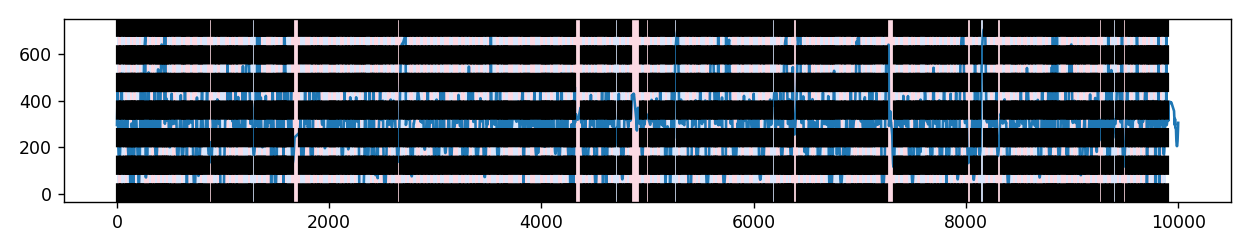

In [105]:
import ruptures as rpt

frame_lim = 10000

# Cut signals
Xb = Xb[:frame_lim]
Yb = Yb[:frame_lim]

# signal
signal_x = np.array(Xb)
signal_y = np.array(Yb)

# detection
result = detect_hits(signal_x, signal_y)

# display
rpt.display(signal_y, result, result)
plt.show()

In [97]:
# New hit detection
import tensorflow as tf
import keras
hitnet_model = keras.models.load_model('./../TrackNetv2/3_in_3_out/hitnet_weights')

In [98]:
hitnet_model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_63 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 17        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
______________________________________________________

In [19]:
def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

court_pts = read_court('./data/%s_court.out' % root_name)

In [99]:
num_consec = 5#int(hitnet_model.input_shape[1] / 2)
corner_coords = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()

x_list = []
for i in range(num_consec):
    end = len(Xb)-num_consec+i+1
    x = np.array(list(zip(Xb[i:end], Yb[i:end])))
#     x = np.hstack([x, np.array([corner_coords for j in range(i, end)])])
    x_list.append(x)
x_inp = np.hstack(x_list)

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = MinMaxScaler()
# scaler.fit(x_inp)
# x_inp = scaler.transform(x_inp)

y_pred = np.ndarray.flatten(hitnet_model.predict(x_inp))

<IPython.core.display.Javascript object>


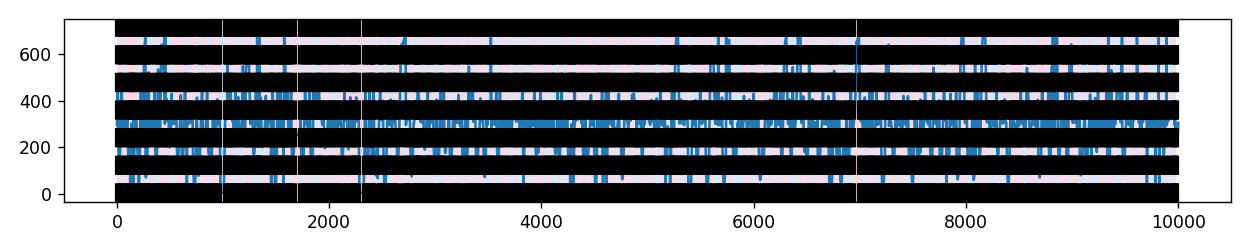

In [100]:
detections = np.where(y_pred > 0.5)[0]
result = []
for t in detections:
    if len(result) == 0 or result[-1] < t - fps / 3:
        result.append(t)
        
rpt.display(signal_y, result, result)
plt.show()

In [13]:
'''
The court looks like this:
A-B-----C-----*-D
| |     |     | |
E-*-----*-----*-*
| |     |     | |
| |     |     | |
| |     |     | |
F---------------*
| |           | |
| |           | |
*---------------*
| |     |     | |
| |     |     | |
| |     |     | |
*-*-----*-----*-*
| |     |     | |
G-*-----*-----*-X

AC/AD = 1/2
AB/AD = 1.5/20
AE/AF = 2.5/15.5
AF/AG = 15.5/44
'''
class Court:
    eps = 0.01
    def __init__(self, corners):
        # The corners must be in the order ADG (or some symmetry of it)
        npcorners = np.stack([np.array(c) for c in corners])
        lcorners = np.array([[0, 0], [1, 0], [0, 1], [1,1]])
        H, mask = cv2.findHomography(lcorners, npcorners, cv2.RANSAC, 2.0)
        self.H = H
        self.inv_H = np.linalg.inv(H)
        
        def to_coord(u, v):
            X = H @ np.array([u, v, 1])
            return X[:2] / X[2]
        
        # ratios of the shorter side
        self.sr = [0, 1.5/20, 1./2, 1-1.5/20, 1]
        self.lr = [0, 2.5/44, 15.5/44, 1/2, 1-15.5/44, 1-2.5/44, 1]
        self.points = []
        for v in self.lr:
            for u in self.sr:
                p = to_coord(u, v)
                self.points.append(p)
                
        self.lines = []
        # Draw the horizontals
        for v in self.lr:
            for i in range(1, len(self.sr)):
                up, u = self.sr[i-1], self.sr[i]
                p, c = to_coord(up, v), to_coord(u, v)
                self.lines.append((p, c))
        
        # Draw the verticals, but skip one line
        for u in self.sr:
            for i in range(1, len(self.lr)):
                vp, v = self.lr[i-1], self.lr[i]
                if (vp == 1./2 or v == 1./2) and u == 1./2:
                    continue
                p, c = to_coord(u, vp), to_coord(u, v)
                self.lines.append((p, c))
    
    def draw_lines(self, img):
        cimg = img.copy()
        colour = (0, 0, 255)
        thickness = 3
        for line in self.lines:
            p0, p1 = tuple(line[0].astype(int)), tuple(line[1].astype(int))
            cimg = cv2.line(cimg, p0, p1, colour, thickness)
        return cimg
    
    def pixel_to_court(self, p):
        x = self.inv_H @ np.array([p[0], p[1], 1])
        return x[:2] / x[2]
    
    def in_court(self, p):
        # 0 if not in court, 1 if in upper half, 2 if in lower half
        x = self.pixel_to_court(p)
        if not (-self.eps < x[0] < 1 + self.eps):
            return 0
        if not (-self.eps < x[1] < 1 + self.eps):
            return 0
        
        return 1 + (x[1] > 0.5 - self.eps)
    
    def draw_hit(self, img, pos, colour=(255,0,0)):
        # pos must be a vec in [0,1]^2 representing position on the 2d court
        centre = (int(pos[0] * img.shape[1]), int((1-pos[1]) * img.shape[0]))
        radius = 6
        thickness = -1
        return cv2.circle(img, centre, radius, colour, thickness)

<IPython.core.display.Javascript object>


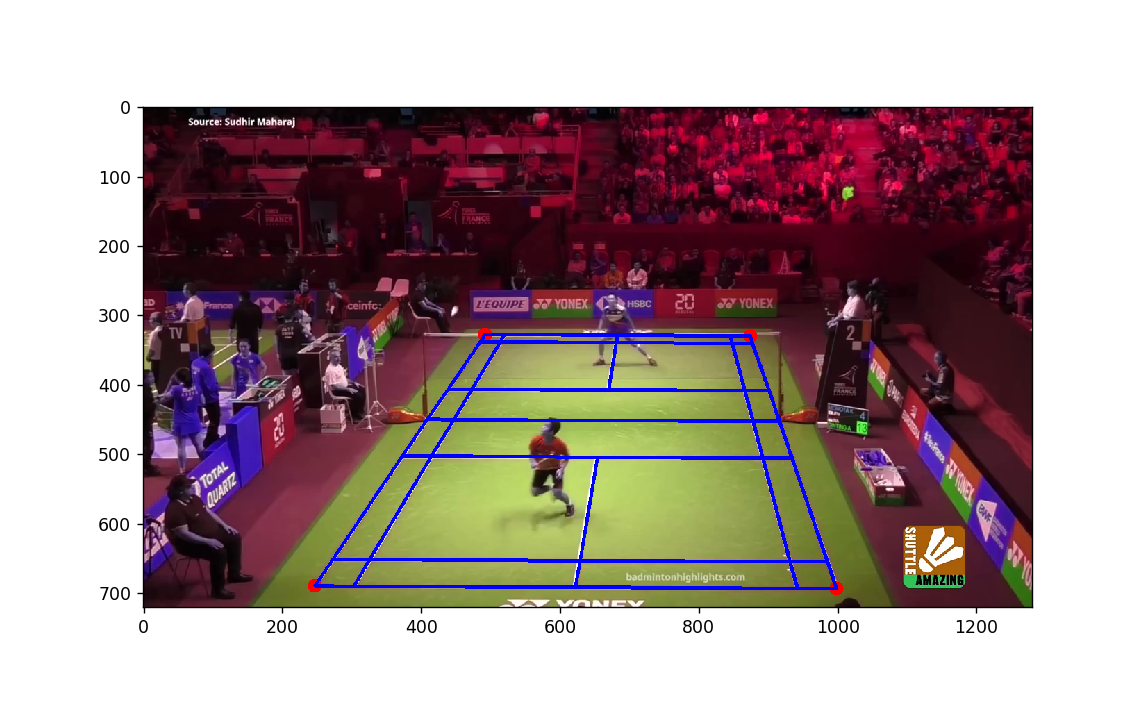

Textarea(value='', description='event:', placeholder='')

In [14]:
from matplotlib.backend_bases import MouseButton

# Let's manually pick out the court pixel coordinates first
ret, frame = cap.read()
fig = plt.figure()
plt.imshow(frame)

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)

# # Define a callback function that will update the textarea
# frames = []
# def onclick(event):
#     txt.value = str(event)  # Dynamically update the text box above
#     if event.button == 1:
#         ret, frame = cap.read()
#         frames.append(frame)
#         plt.imshow(frame)
#     elif event.button == 3:
#         frames.pop()
#         plt.imshow(frames[-1])

# A basic UI function to store the court
corners = []
frames = [frame]
def draw_dot(x, y):
    corners.append((x,y))
    centre = (int(x), int(y))
    radius = 10
    colour = (255, 0, 0)
    thickness = -1
    frame_next = cv2.circle(frames[-1].copy(), centre, radius, colour, thickness)
    frames.append(frame_next)
    plt.imshow(frames[-1])
    
def undraw_dot():
    frames.pop()
    corners.pop()
    plt.imshow(frames[-1])
    
def draw_court(corners):
    # Draws the court once we have the three corners
    court = Court(corners)
    frames[-1] = court.draw_lines(frames[-1])
    plt.imshow(frames[-1])
    
def onclick(event):
    txt.value = str(event)  # Dynamically update the text box above
    if event.button == MouseButton.LEFT:
        x, y = event.xdata, event.ydata
        draw_dot(x, y)
        if len(corners) == 4:
            draw_court(corners)
    elif event.button == MouseButton.RIGHT:
        if len(frames) > 1:
            undraw_dot()

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [77]:
# First, lets filter the poses for only those that are on the court
corners = read_court('./data/%s_court.out' % root_name)
court = Court(corners)

# Next, lets parse the pose file and filter out poses that are not on the court
class Pose:
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (6, 12), (5, 11), (11, 12),  # Body
        (11, 13), (12, 14), (13, 15), (14, 16)
    ]

    joint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear", 
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", 
        "left_wrist", "right_wrist", "left_hip", "right_hip", 
        "left_knee", "right_knee", "left_ankle", "right_ankle" ]
    
    def __init__(self, kplines=[]):
        if not kplines:
            return
        
        keypoints = []
        for line in kplines:
            i, px, py, score = [float(x) for x in line.split()]
            keypoints.append((int(i), np.array([px, py])))
        self.init_from_kp(keypoints)
    
    def init_from_kparray(self, kparray):
        kp = np.array(kparray).reshape((17, 2))
        keypoints = []
        for i in range(17):
            keypoints.append((i, kp[i]))
        self.init_from_kp(keypoints)
        
    # Each pose has 17 key points, representing the skeleton
    def init_from_kp(self, keypoints):
        # Keypoints should be tuples of (id, point)
        self.kp = np.empty((17, 2))
        self.kp[:] = np.NaN

        for i, p in keypoints:
            self.kp[i] = p
        
        self.bx = [min(self.kp[:, 0]), max(self.kp[:, 0])]
        self.by = [min(self.kp[:, 1]), max(self.kp[:, 1])]
        
    
    def draw_skeleton(self, img, colour=(0, 128, 0), thickness=5):
        cimg = img.copy()
        for line in self.skeleton:
            X, Y = self.kp[line[0]], self.kp[line[1]]
            if any(np.isnan(X)) or any(np.isnan(Y)):
                continue
            p0, p1 = tuple(X.astype(int)), tuple(Y.astype(int))
            # For the legs, colour them and the ankles separately
            if line == (13, 15) or line == (14, 16):
                cimg = cv2.line(cimg, p0, p1, (0, 128, 128), thickness)
                cimg = cv2.circle(cimg, p1, 3, (128, 128, 0), thickness=-1)
            else:
                cimg = cv2.line(cimg, p0, p1, colour, thickness)
        return cimg
    
    def get_base(self):
        # Returns the midpoint of the two ankle positions
        return (self.kp[15] + self.kp[16]) / 2.
    
    def get_centroid(self):
        n = 0
        p = np.zeros((2,))
        for i in range(17):
            if any(np.isnan(self.kp[i])) or max(self.kp[i]) == 0:
                continue
            
            n += 1
            p += self.kp[i]
        return p / n
    
    def can_reach(self, p, epsx=3.0, epsy=1.5):
        # if within (1+/-eps) of the bounding box then we can reach it
        dx, dy = self.bx[1] - self.bx[0], self.by[1] - self.by[0]
        return self.bx[0] - epsx * dx < p[0] < self.bx[1] + epsx * dx and \
               self.by[0] - epsy * dy < p[1] < self.by[1] + epsy * dy

In [27]:
from collections import defaultdict

poses = open('./data/%s_poses.out' % root_name)

filtered_poses = defaultdict(dict)

frame_id = -1
pose_lines = []

def filter_pose(fid, kplines):
    if not kplines:
        return
    pose = Pose(kplines)
    in_court = court.in_court(pose.get_base())# or court.in_court(pose.get_centroid())
    if in_court:
        filtered_poses[fid][in_court] = pose
        
def process_poses(fid, lines):
    if not lines:
        return
    
    kplines = []
    for line in lines:
        if 'pose' in line:
            filter_pose(fid, kplines)
            kplines = []
        else:
            kplines.append(line)
    filter_pose(fid, kplines)
            
for line in poses:
    if 'frame' in line:
        process_poses(frame_id, pose_lines)
        pose_lines = []
        frame_id += 1
    else:
        pose_lines.append(line)
process_poses(frame_id, pose_lines)

In [46]:
# We have all the poses now, lets write the player poses to distinct CSV files
import csv
for pid, player in enumerate(['bottom', 'top']):
    filename = './output/%s_player_%s.csv' % (root_name, player)
    file = open(filename, 'w')
    player_writer = csv.writer(file)
    
    row_names = ['frame']
    for joint in Pose.joint_names:
        row_names.append(joint + '_x')
        row_names.append(joint + '_y')
        
    player_writer.writerow(row_names)
    for fid in range(frame_lim):
        row = [fid] + [np.NaN] * 34
        if pid + 1 in filtered_poses[fid]:
            for i, z in enumerate(filtered_poses[fid][pid + 1].kp):
                row[2*i+1] = z[0]
                row[2*i+2] = z[1]
        player_writer.writerow([str(s) for s in row])
    file.close()
    
    # Lets interpolate all the missing values
    player = pd.read_csv(filename)
    player.interpolate(method='slinear', inplace=True)
    player.fillna(method='bfill', inplace=True)
    player.to_csv(filename, index=False)

In [101]:
bottom_player = pd.read_csv('./output/%s_player_bottom.csv' % root_name)
top_player = pd.read_csv('./output/%s_player_top.csv' % root_name)
players = [bottom_player, top_player]

In [107]:
# Filter hits
is_hit = []
last_hit = -1
for fid in result:
    # Check if this impact is close to a pose
    c = np.array([Xb[fid], Yb[fid]])
    reached_by = 0
    dist_reached = 1e99
    for j in range(2):
        xy = players[j].iloc[fid].to_list()[1:]
        pose = Pose()
        pose.init_from_kparray(xy)
#         print(j, pose.get_centroid(), c, np.linalg.norm(c - pose.get_centroid()), reached_by, dist_reached, last_hit)
        if pose.can_reach(c):
            pdist = np.linalg.norm(c - pose.get_centroid())
            if not reached_by or reached_by == last_hit or pdist < dist_reached:
                reached_by = j + 1
                dist_reached = pdist
    if reached_by:
#         print('hit by', reached_by-1)
        last_hit = reached_by
    is_hit.append(reached_by)
print(sum(x > 0 for x in is_hit), len(result))

288 311


In [103]:
print(
    bottom_player.values[result[1]],
    top_player.values[result[1]],
    trajectory.values[result[1]],
    sep='\n'
)

[ 27. 536. 463. 539. 459. 533. 461. 528. 467. 544. 466. 523. 491. 559.
 485. 517. 522. 571. 510. 508. 547. 582. 534. 539. 545. 562. 541. 525.
 580. 578. 569. 523. 627. 597. 598.]
[ 27.         575.         254.         577.         251.
 573.         251.         580.         249.         570.
 252.         589.25       262.         571.27272727 271.09090909
 602.         255.         561.         270.         591.
 246.         570.         265.         592.         284.
 581.         284.         588.         322.         569.77777778
 321.66666667 584.         346.         570.         344.        ]
[27.0 1.0 551.0 162.0 '00:00:01.08' 551.0 162.0]


In [108]:
# Write the hits to video, draw a dot right as the shuttle is struck
outvid = cv2.VideoWriter('output/output_old_model.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (width, height))

court_img = cv2.imread('court.jpg')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
duration = 5
bid = 0
import tqdm.notebook as tq

for i in tq.tqdm(range(frame_lim)):
    ret, frame = cap.read()
    frame = court.draw_lines(frame)
    player_poses = []
    for j in range(2):
        xy = players[j].iloc[i].to_list()[1:]
        pose = Pose()
        pose.init_from_kparray(xy)
        player_poses.append(pose)
        frame = pose.draw_skeleton(frame, colour=(128, 128 + j * 127, 128))
        
    centre = (int(Xb[i]), int(Yb[i]))
    radius = 5
    colour = (0, 255, 0)
    thickness = -1
    frame = cv2.circle(frame, centre, radius, colour, thickness)
    
    if bid < len(result) and abs(result[bid] - i) < duration:
        radius = 10
        colour = (255, 0, 0)
        frame = cv2.circle(frame, centre, radius, colour, thickness)
        
        if i == result[bid]:
            draw_hit = False
            if is_hit[bid]:
                pid = is_hit[bid] - 1
                # Use the athlete's feet position as where its hit
                # Find the foot closer to the shuttle
                cp = np.array([Xb[i], Yb[i]])
                lp, rp = player_poses[pid].kp[15], player_poses[pid].kp[16]
                if np.linalg.norm(cp - lp) < np.linalg.norm(cp - rp):
                    hit_pos = court.pixel_to_court(lp)
                else:
                    hit_pos = court.pixel_to_court(rp)
                colour = (255,0,0)
                draw_hit = True
            else:
                # Assume it hit the ground
                hit_pos = court.pixel_to_court(centre)
                colour = (0,0,255)
                if min(hit_pos) < 0 or max(hit_pos) > 1:
                    draw_hit = False
            if draw_hit:
                court_img = court.draw_hit(court_img, hit_pos, colour)
            
        if i == result[bid] + duration - 1:
            bid += 1
            
    frame[-court_img.shape[0]:, -court_img.shape[1]:] = court_img        
    outvid.write(frame)
outvid.release()

In [31]:
# Find sequences of fully formed rallies
started = False
spos, lpid = 0, 0
is_rally = [0] * frame_lim
num_rallies, rally_len = 0, 0
for i, pid in enumerate(is_hit):
    if pid > 0 and not started:
        # Start the chain
        spos, lpid = i, pid
        started = True
        rally_len = 1
#         print('Started a rally!')
    elif started:
        if pid == 0:
            for j in range(spos, i+1):
                is_rally[j] = 1
            started = False
            print('Rally length:', rally_len)
            num_rallies += 1
#             print('Ended a rally!')
        elif pid == lpid:
            rally_len = 0
            spos = i
#             print('Started a new rally!')
        else:
            lpid = pid
            rally_len += 1
#     print(i, pid)

print(num_rallies)

Rally length: 1
Rally length: 2
Rally length: 0
Rally length: 4
Rally length: 1
Rally length: 1
Rally length: 0
Rally length: 1
Rally length: 1
Rally length: 13
Rally length: 0
Rally length: 5
Rally length: 1
Rally length: 2
Rally length: 6
Rally length: 6
Rally length: 0
Rally length: 1
Rally length: 2
Rally length: 2
Rally length: 0
Rally length: 0
Rally length: 0
Rally length: 1
Rally length: 0
Rally length: 4
Rally length: 0
Rally length: 6
Rally length: 5
Rally length: 0
Rally length: 0
Rally length: 2
Rally length: 1
Rally length: 1
Rally length: 2
Rally length: 1
Rally length: 6
Rally length: 2
Rally length: 3
Rally length: 0
Rally length: 2
Rally length: 1
Rally length: 1
Rally length: 6
44


In [67]:
# Write the hits to video, draw a dot right as the shuttle is struck
outvid = cv2.VideoWriter('output/output_rallies_only.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (width, height))

court_img = cv2.imread('court.jpg')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
duration = 5
bid = 0
for i in tq.tqdm(range(frame_lim)):
    ret, frame = cap.read()
    frame = court.draw_lines(frame)
    player_poses = []
    for j in range(2):
        xy = players[j].iloc[i].to_list()[1:]
        pose = Pose()
        pose.init_from_kparray(xy)
        player_poses.append(pose)
        frame = pose.draw_skeleton(frame, colour=(128, 128 + j * 127, 128))
        
    if bid < len(result) and abs(result[bid] - i) < duration:
        if is_rally[i]:
            centre = (int(Xb[i]), int(Yb[i]))
            radius = 10
            colour = (255, 0, 0)
            thickness = -1
            frame = cv2.circle(frame, centre, radius, colour, thickness)
        
        if i == result[bid] and is_rally[i]:
            if is_hit[bid]:
                pid = is_hit[bid] - 1
                # Use the athlete's feet position as where its hit
                # Find the foot closer to the shuttle
                cp = np.array([Xb[i], Yb[i]])
                lp, rp = player_poses[pid].kp[15], player_poses[pid].kp[16]
                if np.linalg.norm(cp - lp) < np.linalg.norm(cp - rp):
                    hit_pos = court.pixel_to_court(lp)
                else:
                    hit_pos = court.pixel_to_court(rp)
                colour = (255,0,0)
            else:
                # Assume it hit the ground
                hit_pos = court.pixel_to_court(centre)
                colour = (0,0,255)
            court_img = court.draw_hit(court_img, hit_pos, colour)
            
        if i == result[bid] + duration - 1:
            bid += 1
            
    frame[-court_img.shape[0]:, -court_img.shape[1]:] = court_img        
    outvid.write(frame)

KeyboardInterrupt: 